In [ ]:
from sklearn import neural_network, metrics, gaussian_process, preprocessing, svm, neighbors
from sklearn import pipeline, model_selection
from keras import metrics
from keras import backend as K
from scipy.stats import pearsonr
from sklearn import svm, linear_model
import numpy as np
import matplotlib.pyplot as plt
# import microscPSF.microscPSF as msPSF
import PIL
import scipy

from scipy import matrix
from scipy.sparse import coo_matrix
import time
from scipy import linalg
from skimage import color, data, restoration
from skimage.transform import rescale, resize, downscale_local_mean
from scipy.signal import convolve2d as conv2
# import matlab.engine
import pandas as pd

import keras
from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasRegressor
from keras.layers import Dense, Dropout, Activation, Convolution1D, Flatten, Conv1D, UpSampling1D, InputLayer, UpSampling2D, Conv2D, Reshape, Input
from keras.optimizers import SGD
from keras.utils import to_categorical

# from sklearn.preprocessing import Imputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
# from sklearn.experimental import enable_iterative_imputer
from scipy import signal
from sklearn.impute import SimpleImputer

import os

In [ ]:
# %% Creating the test card image

scale = 4.0
psf_w = 16
psf_h = 16
# scale = 1.0
# int(12/scale)
static_psf = np.ones((int(12 / scale), int(12 / scale))) / \
    int(12 / scale)**2  # Boxcar


def psf_guass(w=psf_w, h=psf_h, sigma=3):
    # blank_psf = np.zeros((w,h))
    def gaussian(x, mu, sig):
        return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

    xx, yy = np.meshgrid(np.linspace(-1, 1, w), np.linspace(-1, 1, h))
    return gaussian(xx, 0, sigma) * gaussian(yy, 0, sigma)


static_psf = psf_guass(w=psf_w, h=psf_h, sigma=1 / 5)
plt.imshow(static_psf)


astro = rescale(color.rgb2gray(data.astronaut()), 1.0 / scale)
# astro_blur = rescale(astro_blur, 1.0 / 4)
astro_blur = conv2(astro, static_psf, 'same')

# Add Noise to Image
astro_noisy = astro_blur.copy()
astro_noisy += (np.random.poisson(lam=25, size=astro_blur.shape) - psf_w) / 255.
# astro_blur
# deconvolved_RL = restoration.richardson_lucy(astro_blur, psf, iterations=100)
astro_blur = astro_noisy
plt.imshow(astro_noisy)
plt.imshow(static_psf)

# plt.imshow(deconvolved_RL)

Build measurement matrix.


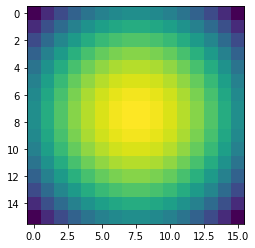

In [6]:
# %% Build measurement matrix.
print("Build measurement matrix.")
# s H = [h_i,j] each row is a line of PSF centered on x,y filled with zeros

N_v = np.ma.size(astro);N_v
N_p = np.ma.size(astro_blur);N_p
measurement_matrix = matrix(np.zeros((N_p, N_v)))

zero_image = np.zeros_like(astro)
astro_shape = astro.shape

x_astro, y_astro = astro_blur.shape
xx_astro, yy_astro = np.meshgrid(np.linspace(-1, 1, x_astro),
                                    np.linspace(-1, 1, y_astro))
psf_window_w, psf_window_h = (psf_w, psf_h)
psf_window_volume = np.full((psf_window_w, psf_window_h, N_v), np.NaN)

illumination = np.cos(64 / 2 * np.pi * xx_astro)

def sigma_scale(r_dist):
    return (r_dist + 0.01) * 3

plt.imshow(psf_guass(w=psf_window_w,
                     h=psf_window_h,
                     sigma=sigma_scale(1)))

r_map = np.sqrt(xx_astro**2 + yy_astro**2)

psf_current = psf_guass(w=psf_window_w,
                        h=psf_window_h,
                        sigma=sigma_scale(r_map.max().max()))
plt.imshow(psf_current)

In [2]:
r_dist = np.empty(N_v)
sigma = np.empty(N_v)
psf_window_volume = np.empty((N_v,psf_w, psf_h))

plt.imshow(r_map)
plt.imshow(illumination)
# for i in np.arange(N_v):
#     coords = np.unravel_index(i,astro.shape)
#     print(r_map[coords])

NameError: name 'np' is not defined

In [8]:
for i in np.arange(N_v):
    coords = np.unravel_index(i, astro.shape)
    r_dist = r_map[coords]
    sigma = sigma_scale(r_map[coords])
    psf_current = psf_guass(w=psf_window_w,
                            h=psf_window_h,
                            sigma=sigma * illumination[coords])
    psf_current = psf_guass(w=psf_window_w,
                            h=psf_window_h,
                            sigma=sigma)
    # psf_current = psf_guass(w=psf_window_w,
    #                         h=psf_window_h,
    #                         sigma=sigma[i])
    psf_window_volume[i, :, :] = psf_current
    delta_image = np.zeros_like(astro)
    delta_image[np.unravel_index(i, astro_shape)] = 1
    delta_PSF = scipy.ndimage.convolve(delta_image, psf_current)
    measurement_matrix[i, :] = delta_PSF.flatten()
    # plt.imshow(psf_current)
    # plt.imsave(f'./output/psfs/{str(i).zfill(6)}.png',psf_window_volume[:,:,i])
#     plt.show()
# pd.DataFrame(measurement_matrix)
astro_noisy_vector = np.matrix(astro_noisy.flatten()).transpose()
# plt.imshow(measurement_matrix)
# plt.show()
# plt.imshow(static_psf)

In [ ]:
# %% Begin RL matrix deconvolvution - Nuke beads

print("Nuke rows and backup files")

beads = 1000


rows_to_nuke = np.random.choice(
    np.arange(measurement_matrix.shape[0]), measurement_matrix.shape[0] - beads,replace=False)
rows_to_nuke
# rows_to_nuke
psf_window_volume_nuked = psf_window_volume.copy()
psf_window_volume_nuked[rows_to_nuke,:, :] = np.NaN

# plt.imshow(np.reshape(psf_window_volume_nuked,(128*128,10*10)))

H_nuked = measurement_matrix.copy()
H_nuked[rows_to_nuke,:] = np.NaN
# H_nuked.shape
# np.sum(np.isfinite(H_nuked[:,0]))
# plt.imshow(H_nuked)
# plt.imshow(measurement_matrix)
plt.imsave('./output/H_nuked.png', H_nuked)

image_width,image_height = np.sqrt(measurement_matrix.shape).astype(np.int)
array_size_4d = [image_width,
                image_height,
                image_width,
                image_height]

measurement_matrix_4d_nuked = np.reshape(np.array(H_nuked),array_size_4d)
measurement_matrix_4d = np.reshape(np.array(measurement_matrix),array_size_4d)

In [12]:
np.save('./data/measurement_matrix_4d_nuked',measurement_matrix_4d_nuked)
np.save('./data/measurement_matrix_4d',measurement_matrix_4d)

np.save('./data/psf_window_volume_nuked',psf_window_volume_nuked)
np.save('./data/psf_window_volume',psf_window_volume)
# psf_window_volume_nuked.shape